# **TP Cours Textmining** 
#### *Etude portée sur les tweets de deux politiques français*

*05-02-2021*

Les objectifs de ce TP sont : 
- Travailler sur du texte français
- Analyser les données 
- Reprendre les acquis développés dans les TP précédents
- Découvrir de nouveaux outils : scattertext
- Prédire qui a posté un tweet 

## **1. Installation des packages**

In [1]:
!pip install scattertext
!pip install spacy
!pip install nltk
!pip install termcolor

     |████████████████████████████████| 7.3 MB 4.6 MB/s 
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9309 sha256=993b44a93835f459ae6262f4df3b1b08581a92555ce2f653cb56e7780b27f6a0
  Stored in directory: /root/.cache/pip/wheels/cb/19/58/4e8fdd0009a7f89dbce3c18fff2e0d0fa201d5cdfd16f113b7
Successfully built flashtext
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
!python -m spacy download fr_core_news_md

     |████████████████████████████████| 88.6 MB 1.4 MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-py3-none-any.whl size=90338488 sha256=2b5d6093859fe9d3f2caeb0bb0772d6e818e699d96a9bedfd097b04c531bb414
  Stored in directory: /tmp/pip-ephem-wheel-cache-o2l5wbnw/wheels/2e/26/ff/ce93eb966e7176ebe81e6c98209582e13e108cdd2d6d636df0
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time
import datetime

# Modules de traitement du texte
import spacy
import fr_core_news_md
import nltk
import re
from termcolor import colored

# Modules pour le wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Module pour scattertext
import scattertext as st

# Modules de modélisation
from sklearn.utils.fixes import loguniform
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# chemin où se trouve le jeu de données (tweets_politics_2022.csv)
PATH_DATA = '/content/drive/MyDrive/HETIC/NLP/NLP4' #TODO mettre le chemin pour trouver le fichier # 

## **2. Prise en main de la base de données**

Les données ont été extraites via l'API tweepy dans un autre notebook. \
Les tweets de certains candidats à l'élection présidentiels ont été récupérés. 

Regardez les variables à disposition, quelques comptages, s'il y a des données manquantes, quelques graphiques (?), la spécificité des tweets, etc. 

#### Import des données

In [6]:
df_tweets = pd.read_csv(f'{PATH_DATA}/tweets_politics_2022.csv')

In [7]:
df_tweets.shape

(18430, 6)

In [8]:
df_tweets.head()

,id,created_at,favorite_count,retweet_count,text,user_id
0,1487771447992926210,2022-01-30 12:55:29,436.0,193.0,Redonner du sens à la gauche : se rassembler a...,JeanLuc_Melenchon
1,1487400906517848070,2022-01-29 12:23:05,2350.0,1027.0,L’inscription sur les listes électorales c’est...,JeanLuc_Melenchon
2,1487117751084855300,2022-01-28 17:37:55,1145.0,480.0,🔴 Rendez-vous ce dimanche 30 janvier à 20h55 s...,JeanLuc_Melenchon
3,1487104482336989191,2022-01-28 16:45:12,1164.0,437.0,3 solutions pour financer la retraite à 60 ans...,JeanLuc_Melenchon
4,1487080530558476288,2022-01-28 15:10:01,1591.0,551.0,La Méditerranée est le plus grand cimetière du...,JeanLuc_Melenchon


####  Quelques comptages / graphiques

##### Indicateurs simples sur les variables : 
- Y a't'il des données manquantes ? 
- combien de tweets de chaque candidat ? 
- dates minimales / maximales des tweets
- Distribution des favoris et des retweets de chaque candidat

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
    <li> Utiliser .isnull() </li>
    <li><a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html" >pd.value_counts()</a> pour compter le nombre de modalités d'une variable catégorielle </li>
    <li> Convertir la date au bon format avec pd.to_datetime() </li>
    <li> Vous pouvez utiliser la fonction groupby et describe() </li>

</ul>
</p>

In [9]:
# Implémentez la fonction en changeant le None
def check_missing_values(df):
  #TODO
  return df.info() 

check_missing_values(df_tweets)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18430 entries, 0 to 18429
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18430 non-null  int64  
 1   created_at      18430 non-null  object 
 2   favorite_count  18430 non-null  float64
 3   retweet_count   18430 non-null  float64
 4   text            18430 non-null  object 
 5   user_id         18430 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 864.0+ KB


In [10]:
# Combien de tweets dans la base de données pour chacun des candidats ? 
#TODO
df_tweets['user_id'].value_counts()

Emmanuel_Macron        2969
Marine_Lepen           2782
JeanLuc_Melenchon      2756
Eric_Zemmour           2752
Christianne_Taubira    2402
Valerie_Pecresse       2399
Yannick_Jadot          1532
Anne_Hidalgo            838
Name: user_id, dtype: int64

In [11]:
# A quelles dates ont été envoyés les premiers / derniers tweets des candidats ? 
#TODO
df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'])
df_tweets.groupby(['user_id']).created_at.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:677: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result = self.apply(lambda x: x.describe(**kwargs))


,count,unique,top,freq,first,last
user_id,,,,,,
Anne_Hidalgo,838,825,2021-12-24 18:08:50,3,2021-07-12 15:29:23,2022-01-30 10:58:47
Christianne_Taubira,2402,2394,2021-11-18 19:35:29,3,2011-08-26 04:30:30,2022-01-30 14:00:01
Emmanuel_Macron,2969,2751,2019-12-03 13:49:09,4,2018-11-29 12:22:40,2022-01-29 19:49:37
Eric_Zemmour,2752,2707,2021-09-23 22:39:59,3,2020-12-18 22:18:49,2022-01-29 21:58:31
JeanLuc_Melenchon,2756,2752,2022-01-21 19:23:57,2,2021-09-13 08:57:51,2022-01-30 12:55:29
Marine_Lepen,2782,2770,2021-12-27 19:08:11,3,2020-02-10 21:38:13,2022-01-30 12:17:02
Valerie_Pecresse,2399,2399,2022-01-29 17:54:29,1,2018-06-20 09:40:14,2022-01-29 17:54:29
Yannick_Jadot,1532,1515,2021-10-25 11:10:54,3,2021-02-14 11:24:25,2022-01-29 21:51:04


In [12]:
# Quelle est la distribution des favoris et retweets des candidats  ?
#TODO
df_tweets.groupby(['user_id'])['favorite_count', 'retweet_count'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


favorite_count                                            \
                             count         mean           std   min      25%   
user_id                                                                        
Anne_Hidalgo                 838.0   386.239857   1809.381945   8.0   132.00   
Christianne_Taubira         2402.0   246.313489   1072.492611   0.0    17.00   
Emmanuel_Macron             2969.0  6078.357696  12216.089485  96.0  1457.00   
Eric_Zemmour                2752.0  3376.126090   2900.967194  57.0  1520.25   
JeanLuc_Melenchon           2756.0   557.383527   1011.128668  43.0   133.00   
Marine_Lepen                2782.0  1273.794033   1181.952814  59.0   535.25   
Valerie_Pecresse            2399.0   299.619842    406.906166   0.0   105.00   
Yannick_Jadot               1532.0   154.718016    200.760908   0.0    36.00   

                                               retweet_count               \
                        50%      75%       max         count         mean   
user_id                                                                     
Anne_Hidalgo          211.0   334.00   47058.0         838.0    98.097852   
Christianne_Taubira    44.0   145.00   39010.0        2402.0   137.960866   
Emmanuel_Macron      2755.0  5756.00  204235.0        2969.0  1088.372853   
Eric_Zemmour         2487.5  4229.75   34664.0        2752.0   844.556686   
JeanLuc_Melenchon     258.0   558.25   21247.0        2756.0   194.824746   
Marine_Lepen          883.0  1573.75   14474.0        2782.0   432.787563   
Valerie_Pecresse      192.0   350.50    7622.0        2399.0    98.312213   
Yannick_Jadot          99.0   199.25    2778.0        1532.0    60.967363   

                                                                         
                             std   min     25%    50%      75%      max  
user_id                                                                  
Anne_Hidalgo          177.219356   1.0   34.00   68.0   113.00   2900.0  
Christianne_Taubira   553.241746   0.0   24.00   46.5   102.75  15718.0  
Emmanuel_Macron      2743.806652  20.0  305.00  514.0   950.00  64283.0  
Eric_Zemmour          783.894937  13.0  368.00  613.0  1040.00   8698.0  
JeanLuc_Melenchon     276.502632  20.0   63.00  106.0   216.00   5719.0  
Marine_Lepen          364.430943  24.0  202.25  311.0   531.00   4097.0  
Valerie_Pecresse      142.986371   0.0   35.00   65.0   112.00   3611.0  
Yannick_Jadot          72.798983   0.0   13.00   40.0    86.00   1090.0

##### Répartition du nombre de retweets / favoris dans le temps 

In [13]:
def visualize_count_favorites(df, userID) : 
  
  ''' Cette fonction permet de visualiser le nombre de favoris et de retweets 
  sur toute la période pour un user_id donné '''

  df_temp = df.loc[df["user_id"] == userID]
  ylabels = ["favorite_count", "retweet_count"]

  print("Représentation des nombres de retweets et de favoris de chaque tweet de {} par date".format(userID))
  fig = plt.figure(figsize=(13,3))
  fig.subplots_adjust(hspace=0.01,wspace=0.01)

  n_row = len(ylabels)
  n_col = 1
  for count, ylabel in enumerate(ylabels):
      ax = fig.add_subplot(n_row, n_col, count + 1)
      ax.plot(df_temp["created_at"], df_temp[ylabel])
      ax.set_ylabel(ylabel)
  
  plt.show()

Représentation des nombres de retweets et de favoris de chaque tweet de JeanLuc_Melenchon par date


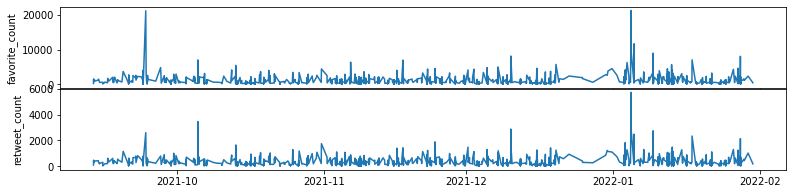



Représentation des nombres de retweets et de favoris de chaque tweet de Marine_Lepen par date


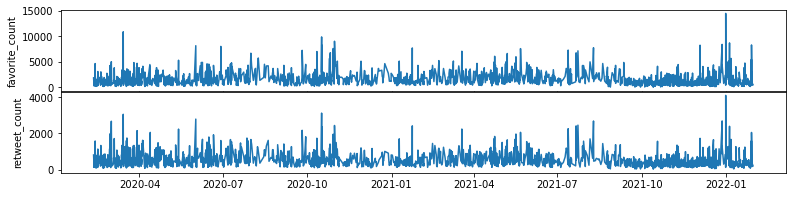

In [14]:
visualize_count_favorites(df_tweets, "JeanLuc_Melenchon")
print("\n")
visualize_count_favorites(df_tweets, "Marine_Lepen")

> **Question** : Qu'observe-t'on ? 

**Réponse** : TODO

##### Taille des tweets par politique 

Est-ce que des candidats font des tweets + ou - longs que d'autres ? 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
    <li> Utilisez la fonction <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html" >.split()</a> pour calculer la taille des tweets</li>
    <li> Vous pouvez utiliser la fonction groupby et describe() </li>

</ul>
</p>

In [15]:
# Calcul d'une variable contenant le nombre de mots de chaque tweets
#TODO
df_tweets['number_words'] = df_tweets['text'].apply(lambda x: len(x.split(" ")))
df_tweets.head()

,id,created_at,favorite_count,retweet_count,text,user_id,number_words
0,1487771447992926210,2022-01-30 12:55:29,436.0,193.0,Redonner du sens à la gauche : se rassembler a...,JeanLuc_Melenchon,22
1,1487400906517848070,2022-01-29 12:23:05,2350.0,1027.0,L’inscription sur les listes électorales c’est...,JeanLuc_Melenchon,48
2,1487117751084855300,2022-01-28 17:37:55,1145.0,480.0,🔴 Rendez-vous ce dimanche 30 janvier à 20h55 s...,JeanLuc_Melenchon,14
3,1487104482336989191,2022-01-28 16:45:12,1164.0,437.0,3 solutions pour financer la retraite à 60 ans...,JeanLuc_Melenchon,40
4,1487080530558476288,2022-01-28 15:10:01,1591.0,551.0,La Méditerranée est le plus grand cimetière du...,JeanLuc_Melenchon,45


In [16]:
# Calcul de la distribution de la variable pour chaque politique
#TODO
df_tweets.groupby(['user_id'])['number_words'].describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
Anne_Hidalgo,838.0,31.267303,13.742126,2.0,20.00,35.5,43.00,54.0
Christianne_Taubira,2402.0,19.141132,7.272101,1.0,15.00,19.0,22.00,51.0
Emmanuel_Macron,2969.0,29.733917,13.062980,1.0,20.00,32.0,41.00,57.0
Eric_Zemmour,2752.0,24.950218,12.591651,1.0,15.00,25.0,35.00,55.0
JeanLuc_Melenchon,2756.0,33.416909,10.545967,2.0,26.00,35.0,41.25,58.0
Marine_Lepen,2782.0,35.435298,10.279059,1.0,30.25,38.0,43.00,56.0
Valerie_Pecresse,2399.0,35.186744,10.185771,1.0,30.00,38.0,42.00,58.0
Yannick_Jadot,1532.0,30.075065,11.260538,1.0,22.00,32.0,39.00,52.0


**Réponse** : TODO

##### Lecture de quelques tweets

In [17]:
def print_famous_tweets(userID, nb_favorites) :

  ''' Cette fonction permet de sélectionner les tweets qui ont eu le plus de favoris 
  pour un user_id donné, et de lire le tweet avec les indicateurs des autres variables de la 
  base de données  
  '''

  df_sub = df_tweets.loc[(df_tweets.user_id==userID) & (df_tweets.favorite_count > nb_favorites),:]
  for irow in range(df_sub.shape[0]):
      df_row = df_sub.iloc[irow,:]
    
      print(df_row["created_at"])
      print("favorite_count={:6} retweet_count={:6}".format(df_row["favorite_count"],df_row["retweet_count"]))
      print(colored(df_row["text"], 'magenta'))
      print("\n")

In [18]:
print_famous_tweets("JeanLuc_Melenchon", 20000)

2022-01-04 20:25:00
favorite_count=21247.0 retweet_count=5719.0
Le Président maîtrise-t-il ce qu'il dit ? 
L'OMS dit « convaincre plutôt que contraindre ». Et lui ? « Emmerder davantage». Consternant.

#Macron


2021-09-24 09:50:27
favorite_count=21142.0 retweet_count=2604.0
Hier, près de 100 000 personnes suivaient le #DebatBFMTV sur #Twitch sur les chaînes de @Sardoche_Lol, @HugoTravers et @DanyCaligula. Mais suite à une réclamation, ces comptes ont été ban 48h. Je le signale à Fogiel. Il faut que ça change pendant la campagne.




In [19]:
print_famous_tweets("Marine_Lepen", 10000)

2021-12-31 16:43:49
favorite_count=14474.0 retweet_count=4097.0
Je suis outrée que le drapeau français ait été remplacé par celui de l’Union européenne sous l’Arc de Triomphe, au-dessus de la tombe du soldat inconnu. 

Cette provocation offense ceux qui se sont battus pour la France. Je demande à E. Macron de rétablir notre drapeau national. https://t.co/sR2IfjV3sG


2020-03-14 06:33:42
favorite_count=10881.0 retweet_count=3051.0
🇫🇷🇮🇹 Les Italiens, unis face à l’épidémie, se retrouvent à leurs balcons pour chanter leur hymne national. Très belles images de communion patriotique. 

Nous sommes de tout cœur avec vous ! ❤️ MLP https://t.co/XKBAtPY1K4




In [20]:
print_famous_tweets("Eric_Zemmour", 20000)

2022-01-05 16:24:53
favorite_count=24894.0 retweet_count=8151.0
Pendant 5 ans, Emmanuel Macron a soigneusement refusé d'« emmerder » les racailles, les gangs, les apprentis-djihadistes, les immigrés hors-la-loi, les antifas et les idéologues qui lavent les cerveaux de nos enfants. Lâche avec les forts, cruel avec les faibles.


2022-01-04 22:53:13
favorite_count=24902.0 retweet_count=7461.0
Emmanuel Macron dit bel et bien : "J'ai envie d'emmerder". Ce n'est pas seulement la déclaration cynique d'un politicien qui veut exister dans la campagne présidentielle. C'est la cruauté avouée, assumée, qui parade devant des Français méprisés.


2021-11-30 11:29:07
favorite_count=34664.0 retweet_count=8698.0
Mes chers compatriotes, je suis candidat à l'élection présidentielle.




> **Question** : Qu'y-a't'il de particulier dans les tweets par rapport à un texte normal ?

**Réponse** : TODO

### **Filtres**

- Filtre sur la date pour ne prendre en compte que la campagne électorale (début septembre 2021)
- Filtre sur certains candidats pour que les traitements ne soient pas trop longs

In [21]:
DATE_MIN = "2021-09-01 00:00:00"

df_tweets = df_tweets.loc[df_tweets["created_at"] >= datetime.datetime.strptime(DATE_MIN, "%Y-%m-%d %H:%M:%S")] 

print(f"Taille du dataframe : {len(df_tweets)}")

Taille du dataframe : 8749


In [22]:
candidats_select = ['JeanLuc_Melenchon', 'Marine_Lepen', 'Eric_Zemmour', 'Emmanuel_Macron'] #TODO : choisir des candidats
                    
df_tweets = df_tweets.loc[df_tweets.user_id.isin(candidats_select)]

print(f"Taille du dataframe : {len(df_tweets)}")

Taille du dataframe : 6356


## **3. Preprocessing du texte**

On va prendre en compte les particularités des tweets pour nettoyer le texte. \
On va tester les techniques de preprocessing des cours précédents sur du texte français : 
- stopwords
- lemmatisation
- tokenisation


### Nettoyage du texte
Dans cette partie du TP, on nettoie le texte pour enlever les mots qui vont rajouter du bruit à l'analyse (et ne rien apporter) \
Pour nettoyer le texte : 
- suppression des chiffres
- suppression de certaines expressions grâce à des expressions régulières
- suppression des stopwords


In [23]:
# on charge le modèle français de spacy
nlp = fr_core_news_md.load()
print(len(nlp.Defaults.stop_words))

# on peut rajouter des stopwords à la liste de spacy de cette manière : 
nlp.Defaults.stop_words |= {"avoir", "falloir", "faire", "monsieur", "direct",
                            "interview", "livetweet", "suivez", r"invité\w+", r"(chaîne )?youtube", "mlp"}

# boucle pour que les stopwords ajoutés fonctionnent
for word in nlp.Defaults.stop_words :
    for w in (word, word[0].capitalize(), word.upper()):
        lex = nlp.vocab[w]
        lex.is_stop = True

# nombre de stopwords 
len(nlp.Defaults.stop_words)

600


610

> **Conseil** :  Regarder toujours la liste entière de stopwords proposés pour enlever certains mots qui seraient utiles dans votre étude ou rajouter des stopwords non présents dans la liste

La cellule ci-dessous donne un exemple d'informations que peut donner Spacy : 

In [24]:
doc = nlp("Demain je travaille \\n\\n à la maison. #fatigué @hetic \\n https://test.com")

list_spacy = []
                
for token in doc : 
  list_spacy.append([token.text,
                        token.idx,
                        token.lemma_,
                        token.is_punct,
                        token.is_space,
                        token.is_alpha,
                        token.shape_,
                        token.pos_,
                        token.tag_,
                        token.ent_type_])
  
exemple_spacy = pd.DataFrame(list_spacy, columns=["text", "idx","lemma","is_punct","is_space","is_alpha","shape","pos","tag","ent_type"])
exemple_spacy

,text,idx,lemma,is_punct,is_space,is_alpha,shape,pos,tag,ent_type
0,Demain,0,demain,False,False,True,Xxxxx,ADV,ADV___,
1,je,7,je,False,False,True,xx,PRON,PRON__Number=Sing|Person=1,
2,travaille,10,travaille,False,False,True,xxxx,VERB,VERB__Mood=Ind|Number=Sing|Person=1|Tense=Pres...,
3,\n\n,20,\n\n,False,False,False,\x\x,ADJ,ADJ___,
4,à,25,à,False,False,True,x,ADP,ADP___,
5,la,27,le,False,False,True,xx,DET,DET__Definite=Def|Gender=Fem|Number=Sing|PronT...,
6,maison,30,maison,False,False,True,xxxx,NOUN,NOUN__Gender=Fem|Number=Sing,
7,.,36,.,True,False,False,.,PUNCT,PUNCT___,
8,#,38,#,True,False,False,#,NOUN,NOUN__Gender=Fem|Number=Sing,
9,fatigué,39,fatiguer,False,False,True,xxxx,VERB,VERB__Gender=Masc|Number=Sing|Tense=Past|VerbF...,


Expressions régulières pour nettoyer le texte 

In [25]:
regexp_link = re.compile(r"http\S+") # suppression des liens
regexp_number = re.compile(r"\d+[h., ]?\d*") # suppression des chiffres

**TODO** : Créer une expression régulière pour supprimer les hashtags et @ 

Remplacer le #TODO dans la cellule suivante par une expression régulière.

Votre regexp fonctionne si vous trouver " ça  marche  !!"

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
Lorsque vous cherchez à créer des expressions régulières, vous pouvez vous aider en allant sur ce site : <a href="https://regex101.com/" >regex101.com</a> 
</p> 

In [26]:
# suppression des hashtags et @
regexp_hashtags = re.compile(r"[#@]\S+")    

test_hashtags = "#Fuck ça #ne marche @pas !!"
re.sub(regexp_hashtags, "", test_hashtags)

' ça  marche  !!'

Création de la fonction de nettoyage du texte 

**TODO** : coder plusieurs fonctions :      
- une fonction `clean_text_spacy` qui prend en entrée un tweet et utilise spacy pour :     
    - supprimer les ponctuations ; 
    - supprimer les stopwords ; 
    - supprimer les caractères de type espace (/n, /t, etc.)
Cette fonction garde les tokens entiers
- une fonction `clean_lemmatize` :     
    - supprimer les ponctuations ; 
    - supprimer les stopwords ; 
    - supprimer les caractères de type espace (/n, /t, etc.)
Cette fonction garde non pas les tokens entiers, mais les lemmes. 
- une fonction chapeau `preprocess_tweet` qui : 
  - met les mots en minuscule
  - supprime les mots des expressions régulières
  - au choix applique la fonction `clean_text_spacy` ou `clean_lemmatize`

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
Lorsque vous utilisez les fonctions de spacy, vous allez potentiellement les tokeniser directement (et récupérer une liste au lieu d'un texte). Pour éviter cela, transformez le résultat de cette manière :    

```
result = " ".join(result)
```

</p> 

In [27]:
def clean_txt_spacy(doc):
  doc = nlp(doc)
  txt = " ".join([token.text for token in doc if not token.is_stop and not token.is_space and not token.is_punct])
  return txt

def clean_lemmatize(doc):
  lemmatized_txt = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_space and not token.is_punct])
  return lemmatized_txt


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
- Utiliser re.sub() pour supprimer les liens, hashtags, chiffres
</p> 

In [28]:
def preprocess_tweet(text, lemmatizing = True):

  '''Fonction permettant de nettoyer le texte. Elle renvoie un string (pas de tokenisation encore)'''
  text_clean = text.lower().encode('utf-8').decode('utf-8')
  #TODO : supprimer du texte les liens, hashtags et chiffres avec les regexp précédentes
  text_clean = re.sub(regexp_link, "", text_clean)
  text_clean = re.sub(regexp_hashtags, "", text_clean)
  text_clean = re.sub(regexp_number, "", text_clean)

  doc = nlp(text_clean)  
  if lemmatizing : 
    preprocessed_tweet = clean_lemmatize(doc)
  else : 
    preprocessed_tweet = clean_txt_spacy(doc)

  return preprocessed_tweet

In [29]:
# exemple pour tester sa fonction 
tweet_test = "Ils Pensaient se moquer #non, ils m'ont donné 1 slogan !😄 \n\n- Entretien à découvrir et partager \n\nhttps://t.co/Yn60Areagu"
preprocess_tweet(tweet_test, lemmatizing=True)

'pensaient moquer donner slogan 😄 entretien découvrir partager'

Réponse attendue : 
```python 
'pensaient moquer donner slogan 😄 entretien découvrir partager'
```

In [30]:
# On peut alors nettoyer nos tweets, et créer une nouvelle colonne, text_preprocess
# cela peut prendre un peu de temps à tourner
df_tweets["text_preprocess"] = df_tweets["text"].apply(lambda tweet : preprocess_tweet(tweet, lemmatizing=True))

In [31]:
# On regarde le résultat du nettoyage du texte
pd.set_option("max_colwidth", None)
df_tweets[["text", "text_preprocess"]].head(10)

,text,text_preprocess
0,Redonner du sens à la gauche : se rassembler avec le Parlement de l'Union Populaire - Tribune de membres du @ParlementPop. \n\nhttps://t.co/JzBPeFNSOz,redonner sens gauche rassembler parlement union populaire tribune membre
1,L’inscription sur les listes électorales c’est jusqu’au 4 mars et c’est le moyen de faire \n✅ la 6e République\n✅ le SMIC à 1400€ nets\n✅ la règle verte \n✅ la retraite à 60 ans\n✅ une France indépendante au service de la paix\n\n➡️ Ça se passe ici : https://t.co/FJUbiFzRFI https://t.co/orrqlIgQ42,inscription liste électoral jusqu’ mars moyen ✅ e république ✅ smic euro net ✅ règle vert ✅ retraite an ✅ france indépendant service paix ➡ ️ passer ici
2,🔴 Rendez-vous ce dimanche 30 janvier à 20h55 sur France 5 pour #cdanslair. https://t.co/Z7nsNC1rg4,🔴 rendre dimanche janvier france
3,3 solutions pour financer la retraite à 60 ans\n\n✅ Égalité salariale femmes-hommes\n✅ Augmenter les cotisations pour les salaires supérieurs à 3400€\n✅ Augmenter les cotisations patronales avec un fond de péréquation inter-entreprises pour que les grosses payent pour les petites https://t.co/WSCD1xX5Qt,solution financer retraite an ✅ égalité salarial femme homme ✅ augmenter cotisation salaire supérieur euro ✅ augmenter cotisation patronal fond péréquation inter-entrepriser gros payer petit
4,"La Méditerranée est le plus grand cimetière du monde. Ceux qui émigrent ne partent pas par plaisir. Il faut donc arrêter les accords commerciaux déséquilibrés. Mais quand les gens sont là, il ne faut pas les maltraiter. Il faut les traiter humainement et dignement.\n\n#FaceABaba https://t.co/K2VLIbH7dI",méditerranée grand cimetière monde émigrer partir plaisir falloir arrêter accord commercial déséquilibré falloir maltraiter falloir traiter humainement dignement
5,Retour d'émission #FaceABaba - Nouvelle note de blog\nhttps://t.co/ayMGflKdv9,émission nouveau note blog
6,"Le jour de mes 50 ans, la fille de Raquel et d'autres m'ont offert un drapeau de la France de 7 mètres de long. On a posé cette petite fille sur ce grand drapeau, tous les larmes aux yeux. Vive la République. #FaceABaba #AvecMelenchon https://t.co/kFfgejSWyz",jour an fille raquel offrir drapeau france mètre long poser petit fille grand drapeau larme oeil république
7,"La majeure partie de la dette publique de la zone Euro appartient à la Banque Centrale Européenne. Il faut geler ces titres, parce que cette dette ne sera jamais remboursée et qu'elle nous empêche de faire les investissements dont nous avons besoin.\n#FaceABaba\n#AvecMelenchon https://t.co/wpCqgJ3omz",majeur partie dette public zone euro appartenir banque central européen falloir geler titre dette jamais rembourser empêche investissement besoin
8,"Dans une entreprise, je propose qu'il n'y ait pas d'écart de salaire de plus de 1 à 20. Comme ça quand le patron décide de s'augmenter, comme dans les entreprises du CAC40, il devra aussi augmenter le salarié qu'il paie au lance-pierre.\n\n#FaceABaba\n#AvecMelenchon https://t.co/pIbQaaInup",entreprise propose y écart salair patron décide augmenter entreprise cac augmenter salarié payer lance pierre
9,"Le peuple français est mal en ce moment. Il a tellement changé entre le moment où on a fait la Constitution de 1958 et aujourd'hui. Avec la 6ème République, c'est le peuple lui-même qui va se refonder. #FaceABaba #AvecMelenchon https://t.co/KCANTPeOBh",peuple français mal moment changer moment constitution èm république peuple refonder


> Le preprocess n'est pas encore parfait, on pourrait enlever les verbes avec du pos-tagging ou bien rajouter l'info de pos-tagging après chaque mot. \
> Supprimer les emojis ou les transformer en texte.

### Tokenisation
On tokenise la colonne de tweets prétraités (preprocess)

**TODO** : utiliser le module nltk pour tokeniser un tweet avec la fonction tokenisation

In [32]:
nltk.download('punkt') # nécessaire pour la tokenisation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [33]:
# Remplir le None dans le code
def tokenisation(tweet):
  tweet_tokenized = nltk.word_tokenize(tweet)
  return(tweet_tokenized)

In [34]:
df_tweets["tokens"] = df_tweets["text_preprocess"].apply(lambda tweet : tokenisation(tweet))

In [35]:
df_tweets[["text_preprocess", "tokens"]].head()

,text_preprocess,tokens
0,redonner sens gauche rassembler parlement union populaire tribune membre,"[redonner, sens, gauche, rassembler, parlement, union, populaire, tribune, membre]"
1,inscription liste électoral jusqu’ mars moyen ✅ e république ✅ smic euro net ✅ règle vert ✅ retraite an ✅ france indépendant service paix ➡ ️ passer ici,"[inscription, liste, électoral, jusqu, ’, mars, moyen, ✅, e, république, ✅, smic, euro, net, ✅, règle, vert, ✅, retraite, an, ✅, france, indépendant, service, paix, ➡, ️, passer, ici]"
2,🔴 rendre dimanche janvier france,"[🔴, rendre, dimanche, janvier, france]"
3,solution financer retraite an ✅ égalité salarial femme homme ✅ augmenter cotisation salaire supérieur euro ✅ augmenter cotisation patronal fond péréquation inter-entrepriser gros payer petit,"[solution, financer, retraite, an, ✅, égalité, salarial, femme, homme, ✅, augmenter, cotisation, salaire, supérieur, euro, ✅, augmenter, cotisation, patronal, fond, péréquation, inter-entrepriser, gros, payer, petit]"
4,méditerranée grand cimetière monde émigrer partir plaisir falloir arrêter accord commercial déséquilibré falloir maltraiter falloir traiter humainement dignement,"[méditerranée, grand, cimetière, monde, émigrer, partir, plaisir, falloir, arrêter, accord, commercial, déséquilibré, falloir, maltraiter, falloir, traiter, humainement, dignement]"


### Analyse du preprocess

On regarde un peu les résultats du preprocessing : 
- combien y a-t-il de mots distincts pour chacun des deux hommes politiques ? 
- Quels sont les mots les plus utilisés par deux candidats de votre choix ? 

Pour cela vous vous aiderez des deux fonctions données ci-dessous

In [36]:
def create_big_tweet_by_userid(userid, col_text) : 

  ''' Fonction pour mettre tous les tweets de chaque politiciens dans un même text (string) '''
  one_big_tweet = " ".join(df_tweets.loc[df_tweets["user_id"] == userid, col_text])
  
  return one_big_tweet
  

In [37]:
def get_n_most_common_words(list_words, n) :

  ''' Fonction permettant de donner les n mots les plus fréquents d'une liste de mots '''
  freq_words = nltk.FreqDist(list_words)
  print(freq_words.most_common(n))


**TODO** : Si on n'utilise pas de preprocessing, quels sont les mots les plus utilisés par les 2 politiciens ?

In [38]:
# Créer un gros tweet pour chacun des deux politiques (qui est la jointure de l'ensemble de ses tweets)
big_tweet_candidate1 = create_big_tweet_by_userid("Marine_Lepen", "text")
big_tweet_candidate2 = create_big_tweet_by_userid("Eric_Zemmour", "text")

# Tokeniser le gros tweet de chacun des politiques
tokens_candidate1 = tokenisation(big_tweet_candidate1)
tokens_candidate2 = tokenisation(big_tweet_candidate2)

# Regarder les 10 mots les plus communs pour chacun des politiques
get_n_most_common_words(tokens_candidate1, 10)
get_n_most_common_words(tokens_candidate2, 10)

[('de', 2179), (',', 1916), ('.', 1663), (':', 1602), ('https', 1322), ('la', 1272), ('’', 1087), ('#', 1032), ('à', 920), ('et', 840)]
[('.', 2699), (',', 2483), ('de', 2170), ('’', 2046), (':', 1919), ('#', 1740), ('la', 1422), ('https', 1418), ('les', 1000), ('et', 922)]


**Réponse** : 

Sans preprocessing, combien y a-t-il de mots distincts pour chaque politique ?

In [39]:
# la fonction set appliquée sur une liste donne une liste d'éléments uniques
print("Nombre de mots distincts dans les tweets du candidat 1 : {}".format(len(set(tokens_candidate1))))
print("Nombre de mots distincts dans les tweets du candidat 2 : {}".format(len(set(tokens_candidate2))))

Nombre de mots distincts dans les tweets du candidat 1 : 8108
Nombre de mots distincts dans les tweets du candidat 2 : 8960


**Réponse** : 

Jean Luc Mélenchon : 11877 \
Eric Zemmour : 8960 \
Marine Lepen : 8108 \
Emmanuel Macron : 4394

**TODO** : même question avec un preprocessing ?


In [40]:
# Créer un gros tweet pour chacun des deux politiques (qui est la jointure de l'ensemble de ses tweets)
big_tweet_candidate1 = create_big_tweet_by_userid("Marine_Lepen", "text_preprocess")
big_tweet_candidate2 = create_big_tweet_by_userid("Eric_Zemmour", "text_preprocess")

# Tokeniser le gros tweet de chacun des politiques
tokens_candidate1 = tokenisation(big_tweet_candidate1)
tokens_candidate2 = tokenisation(big_tweet_candidate2)

# Regarder les 10 mots les plus communs pour chacun des politiques
get_n_most_common_words(tokens_candidate1, 10)
get_n_most_common_words(tokens_candidate2, 10)

[('français', 350), ('📹', 340), ('france', 229), ('🏻', 205), ('👉', 178), ('président', 158), ('pays', 124), ('vouloir', 123), ('🇫', 112), ('🇷', 112)]
[('france', 425), ('français', 414), ('vouloir', 248), ('y', 153), ('être', 142), ('politique', 114), ('falloir', 112), ('macron', 110), ('grand', 109), ('pays', 84)]


In [41]:
print("Nombre de mots distincts dans les tweets du candidat 1 : {}".format(len(set(tokens_candidate1))))
print("Nombre de mots distincts dans les tweets du candidat 2 : {}".format(len(set(tokens_candidate2))))

Nombre de mots distincts dans les tweets du candidat 1 : 4003
Nombre de mots distincts dans les tweets du candidat 2 : 4628


**Réponse** : 

Jean Luc Mélenchon : 5369 \
Eric Zemmour : 4628

### Nuage de mots

On trace un nuage de mots pour chacun des politiques pour voir ce qui ressort

**#TODO** : Faire un nuage de mots pour deux candidats de votre choix avec 30 mots

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
    <li> transformer l'ensemble des tweets d'un politique en un texte unique </li>
    <li> vous pouvez utiliser la fonction WordCloud </li>
</ul>
</p>

Wordcloud des mots lemmatisés de l'ensemble des tweets du candidat 1


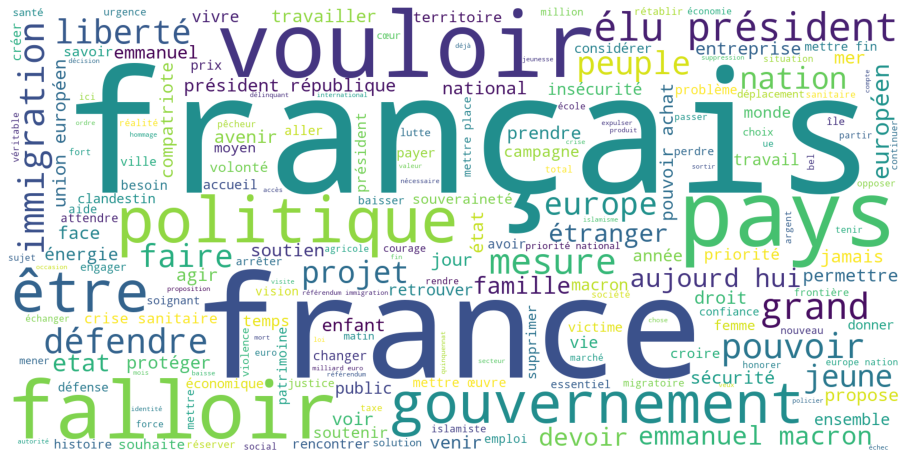

In [42]:
# Faire un texte unique pour les tweets de MLP 
big_tweet_candidate1 = create_big_tweet_by_userid("Marine_Lepen", "text_preprocess")
print("Wordcloud des mots lemmatisés de l'ensemble des tweets du candidat 1")
#Faire le wordcloud
wc = WordCloud(background_color="white", width=1600, height=800)
wc.generate(big_tweet_candidate1)
plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(wc)
plt.show()

Wordcloud des mots lemmatisés de l'ensemble des tweets du candidat 1


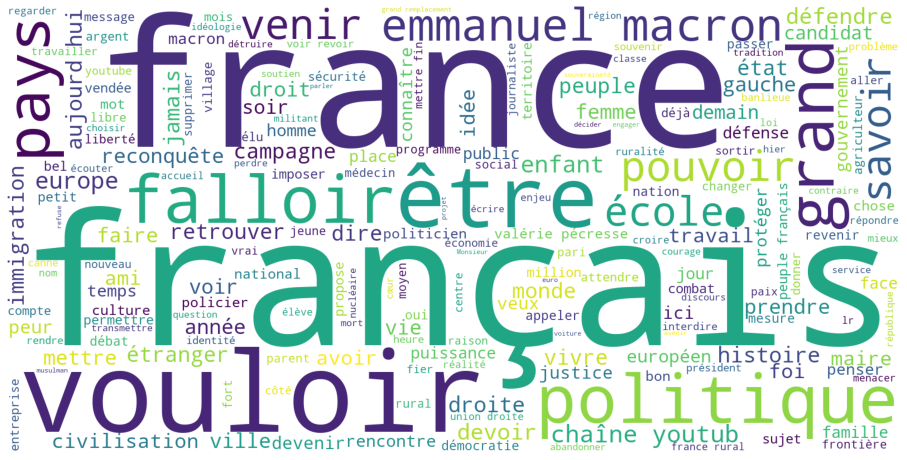

In [43]:
# Faire un texte unique pour les tweets de EZ 
big_tweet_candidate1 = create_big_tweet_by_userid("Eric_Zemmour", "text_preprocess")
print("Wordcloud des mots lemmatisés de l'ensemble des tweets du candidat 1")
#Faire le wordcloud
wc = WordCloud(background_color="white", width=1600, height=800)
wc.generate(big_tweet_candidate1)
plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(wc)
plt.show()

C'est bien beau, mais c'est difficile à analyser, et surtout à comparer... \
On va utiliser scattertext pour comparer réellement le vocabulaire des 2 politiques.

## **4. Scattertext**

Grâce à Scattertext, on va pouvoir comparer de manière visuelle la distinction de vocabulaire utilisé par deux candidats de votre choix. 


On doit d'abord construire un corpus avec nos données : 
- donner la variable de catégorie 
- donner la variable du texte

On peut rajouter le partie ```.compact(st.AssociationCompactor(4000))``` pour ne prendre en compte que les 4000 mots les plus importants dans le scattertext.

**TODO** : créer le corpus avec la fonction donnée ci-dessous

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
    <li> Filtrer en gardant les tweets des deux candidats de votre choix </li>
</ul>
</p>

In [44]:
df_sample = df_tweets.loc[df_tweets.user_id.isin(['Marine_Lepen', 'Eric_Zemmour'])]

# on crée un objet corpus pour scattertext
corpus = st.CorpusFromPandas(data_frame = df_sample,
                             category_col = 'user_id', #TODO
                             text_col = 'text_preprocess', #TODO
                             nlp = nlp).build().compact(st.AssociationCompactor(4000))

Une fois le corpus créé, on peut créer le html avec le scattertext. 

On utilise la fonction ```st.produce_scattertext_explorer``` en donnant les paramètres vus pendant le cours : 
- term_ranker
- term_scorer
- transform 

**TODO** : remplir la fonction en réfléchissant aux paramètres que vous voulez tester.

In [45]:
from scattertext.Scalers import log_scale_standardize
# On crée le html du scattertext
html = st.produce_scattertext_explorer(  corpus
                                       , category                  = 'Eric_Zemmour'
                                       , category_name             = 'Eric Zemmour'
                                       , not_category_name         = 'Marine Lepen'
                                       , minimum_term_frequency    = 10
                                       , pmi_threshold_coefficient = 1
                                       , term_ranker               = st.AbsoluteFrequencyRanker
                                                                    #st.OncePerDocFrequencyRanker
                                       , term_scorer               = st.RankDifference()
                                                                    #st.ScaledFScorePresets(beta=1, one_to_neg_one=True)
                                       , transform                 = st.Scalers.dense_rank
                                                                    #st.Scalers.percentile_ordinal
                                                                    #st.Scalers.log_scale_standardize
                                       , width_in_pixels           = 1000
                                       )

# On enregistre le html
open("tweets_visualisation.html", 'wb').write(html.encode('utf-8'))

990563

**TODO** : regarder le résultat (il apparaitra normalement dans le dossier content du notebook) en téléchargeant le html (cela peut prendre un petit moment avant de s'afficher correctement).

**Question** : Analysez le graphique

## **5. Modélisation**

On souhaite prédire si un tweet provient du compte de Marine Le Pen, de Jean Luc Mélenchon, d'Eric Zemmour ou d'Emmanuel Macron. Pour cela, on a besoin de : 
- Créer un échantillon train / dev
- préparer le text (préprocessing)
- créer des features (plusieurs méthodes : bag of words, counts of words, etc.)
- réaliser l'algorithme
- évaluer la performance du modèle 

### Création des échantillons 

**TODO** : créer un échantillon train (70% du jeu de données total) et un échantillon test 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> Utilisez la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html" >train_test_split</a></li>
  <li> Vous pouvez prendre tout le df_tweet dans le X</li>
  <li> N'oubliez pas de rajouter un random_seed pour avoir des résultats reproductibles</li>
</p> 

In [46]:
df_tweets.head()

,id,created_at,favorite_count,retweet_count,text,user_id,number_words,text_preprocess,tokens
0,1487771447992926210,2022-01-30 12:55:29,436.0,193.0,Redonner du sens à la gauche : se rassembler avec le Parlement de l'Union Populaire - Tribune de membres du @ParlementPop. \n\nhttps://t.co/JzBPeFNSOz,JeanLuc_Melenchon,22,redonner sens gauche rassembler parlement union populaire tribune membre,"[redonner, sens, gauche, rassembler, parlement, union, populaire, tribune, membre]"
1,1487400906517848070,2022-01-29 12:23:05,2350.0,1027.0,L’inscription sur les listes électorales c’est jusqu’au 4 mars et c’est le moyen de faire \n✅ la 6e République\n✅ le SMIC à 1400€ nets\n✅ la règle verte \n✅ la retraite à 60 ans\n✅ une France indépendante au service de la paix\n\n➡️ Ça se passe ici : https://t.co/FJUbiFzRFI https://t.co/orrqlIgQ42,JeanLuc_Melenchon,48,inscription liste électoral jusqu’ mars moyen ✅ e république ✅ smic euro net ✅ règle vert ✅ retraite an ✅ france indépendant service paix ➡ ️ passer ici,"[inscription, liste, électoral, jusqu, ’, mars, moyen, ✅, e, république, ✅, smic, euro, net, ✅, règle, vert, ✅, retraite, an, ✅, france, indépendant, service, paix, ➡, ️, passer, ici]"
2,1487117751084855300,2022-01-28 17:37:55,1145.0,480.0,🔴 Rendez-vous ce dimanche 30 janvier à 20h55 sur France 5 pour #cdanslair. https://t.co/Z7nsNC1rg4,JeanLuc_Melenchon,14,🔴 rendre dimanche janvier france,"[🔴, rendre, dimanche, janvier, france]"
3,1487104482336989191,2022-01-28 16:45:12,1164.0,437.0,3 solutions pour financer la retraite à 60 ans\n\n✅ Égalité salariale femmes-hommes\n✅ Augmenter les cotisations pour les salaires supérieurs à 3400€\n✅ Augmenter les cotisations patronales avec un fond de péréquation inter-entreprises pour que les grosses payent pour les petites https://t.co/WSCD1xX5Qt,JeanLuc_Melenchon,40,solution financer retraite an ✅ égalité salarial femme homme ✅ augmenter cotisation salaire supérieur euro ✅ augmenter cotisation patronal fond péréquation inter-entrepriser gros payer petit,"[solution, financer, retraite, an, ✅, égalité, salarial, femme, homme, ✅, augmenter, cotisation, salaire, supérieur, euro, ✅, augmenter, cotisation, patronal, fond, péréquation, inter-entrepriser, gros, payer, petit]"
4,1487080530558476288,2022-01-28 15:10:01,1591.0,551.0,"La Méditerranée est le plus grand cimetière du monde. Ceux qui émigrent ne partent pas par plaisir. Il faut donc arrêter les accords commerciaux déséquilibrés. Mais quand les gens sont là, il ne faut pas les maltraiter. Il faut les traiter humainement et dignement.\n\n#FaceABaba https://t.co/K2VLIbH7dI",JeanLuc_Melenchon,45,méditerranée grand cimetière monde émigrer partir plaisir falloir arrêter accord commercial déséquilibré falloir maltraiter falloir traiter humainement dignement,"[méditerranée, grand, cimetière, monde, émigrer, partir, plaisir, falloir, arrêter, accord, commercial, déséquilibré, falloir, maltraiter, falloir, traiter, humainement, dignement]"


In [80]:
df_train, df_test, y_train, y_test = train_test_split(df_tweets, df_tweets['user_id'], test_size=0.30, random_state=16)

In [81]:
print(f"Nombre de tweets dans l'échantillon train : {len(df_train)}")
print(f"Nombre de tweets dans l'échantillon test : {len(df_test)}")

Nombre de tweets dans l'échantillon train : 4449
Nombre de tweets dans l'échantillon test : 1907


**Réponse** : 

Nombre de tweets dans l'échantillon train : 4449 \
Nombre de tweets dans l'échantillon test : 1907

### Modèle de régression multinomiale sans gridsearch 

- Transformer le texte de df_train et df_test en vecteurs pour le modèle
- Utiliser la régression logistique multinomiale sans paramètre
- Regarder les paramètres sélectionnés
- Regarder le score sur l'échantillon test

**#TODO** : transformer df_train pour que ce ne soit plus des tweets, mais des vecteurs grâce à <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html" >TfidfVectorizer</a> 

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>

La fonction TfidfVectorizer a des paramètres que vous pouvez choisir : 
<ul>

- Combien de n-grams : vous considérez mot par mot ou bien également des groupes de 2 mots
- max_df : si vous voulez enlever un pourcentage de mots les plus fréquents
- min_df : si vous voulez enlever un pourcentage de mots les moins fréquents
</p> 

In [82]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5)
X_tfidf = vectorizer.fit_transform(df_train['text_preprocess'])

**#TODO** : créer le modèle de régression logistique (OVR) et entrainer le modèle sur les données d'apprentissage

In [83]:
# initialiser le modèle 
model = LogisticRegression(multi_class='ovr', random_state=27)

# entrainer le modèle avec les données d'apprentissage
model_default_fit = model.fit(X_tfidf, y_train)

In [84]:
# vous pouvez voir les paramètres du modèle 
model_default_fit.get_params(deep=True)

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 27,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

**#TODO** : Regarder la performance du modèle sur l'échantillon train et test (accuracy)

<details>    
<summary>
    <font size="3"**texte en gras** color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> N'oubliez pas de transformer le texte de l'échantillon test en vecteur en amont</li>
  <li> Vous pouvez utiliser la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">score</a>  du modèle</li>
  
</p> 

In [85]:
#TODO
X_test = vectorizer.transform(df_test['text_preprocess'])
model_default_fit.score(X_test, y_test)

0.7168327215521761

In [86]:
model_default_fit.score(X_tfidf, y_train)

0.8428860418071477

**Question** : Quel est l'accuracy sur l'échantillon test ? 

**Résultat** : **#TODO**

**#TODO** : regarder plus en détail ce que donne le modèle : 

In [87]:
print("le 1er tweet de l'échantillon test a été prédit : ")
print(model_default_fit.predict(X_test[0]))

le 1er tweet de l'échantillon test a été prédit : 
['JeanLuc_Melenchon']


In [88]:
model_default_fit.predict_proba(X_test[0])

array([[0.14706462, 0.19421587, 0.57889225, 0.07982725]])

**Question** : que retourne la ligne de code ci-dessus ?

**Réponse** : 

### Mise en place de la RandomSearch

On veut mettre en place une randomSearch pour sélectionner les meilleurs paramètres qu'on a choisi d'évaluer via la méthode de cross-validation : 
- on établit d'abord la grille de paramètres que l'on veut tester
- on effectue la RandomSearch
- on regarde les résultats sut l'échantillon test

In [89]:
# Paramètres à tester données, vous pouvez modifier pour tester d'autres paramètres
dict_params = dict(prep__text_preprocess__max_df=[0.99, 0.95, 0.9],
                   prep__text_preprocess__min_df=[2, 5, 10],
                   clf__C = [1, 20, 50],
                   clf__penalty = ['l2'],
                   clf__multi_class=['ovr', 'multinomial'])

**#TODO** : Entrainer la Randomsearch avec les paramètres ci-dessus sur les données d'apprentissage avec de la cross validation

NB : une pipeline a été mise en place dans la cellule ci-dessous afin de pouvoir tester également les paramètres du TFIDF. 

<details>    
<summary>
    <font size="3"**texte en gras** color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> Vous pouvez utiliser la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html">RandomizedSearchCV</a></li>
  
</p> 

In [93]:
# Entrainer le randomizedsearch 

# Vectorisation de la variable text_preprocess
text_transformer_tfidf =  TfidfVectorizer()
preprocess = ColumnTransformer([("text_preprocess", text_transformer_tfidf, "text_preprocess")], 
                               remainder="drop")

# Type de modèle à tester
model = LogisticRegression(random_state=54269, max_iter=1000)

# Pipeline qui combine le preprocess et le modèle
prep_model = Pipeline(steps=[('prep',preprocess),
                             ('clf', model)])

# RANDOMIZED SEARCH
##### A MODIFIER A PARTIR D'ICI #####
random_search = RandomizedSearchCV( prep_model,
                                   dict_params,
                                   cv=5,  # cross validation de 5 échantillons
                                   n_iter=20,
                                   random_state=5439676,
                                   n_jobs=-1,
                                   verbose=1)
### FIN MODIFICATION ### 

best_rd_model = random_search.fit(df_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [94]:
# Meilleurs paramètres sélectionnés par la randomSearch
best_rd_model.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('text_preprocess',
                                                  TfidfVectorizer(max_df=0.99,
                                                                  min_df=2),
                                                  'text_preprocess')])),
                ('clf',
                 LogisticRegression(C=20, max_iter=1000, multi_class='ovr',
                                    random_state=54269))])

Quelle accuracy le meilleur modèle a-t'il atteint sur l'échantillon train ? 

In [95]:
# Résultats du meilleur modèle sur l'échantillon train 
best_rd_model.best_score_

0.7428637150693242

**#TODO** : on évalue la performance en calculant l'accuracy du modèle sélectionné par randomsearch sur l'échantillon test



In [96]:
best_rd_model.score(df_test, y_test)

0.7498689040377556

### Evaluation de la performance du modèle 

On va calculer la matrice de confusion sur l'échantillon test

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Aide</b></font>
</summary>
<p>
<ul>
  <li> Prédire les candidats de df_test dans un premier temps </li>
  <li> Vous pouvez utiliser la fonction <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html" >ConfusionMatrixDisplay</a></li>
  
</p> 

In [61]:
from sklearn.metrics import confusion_matrix

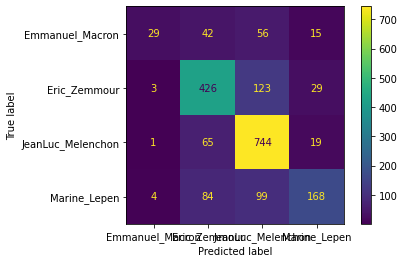

In [97]:
#matrice de confusion
#confrontation entre Y observé sur l’éch. test et la prédiction

pred_test = model_default_fit.predict(X_test)
cm = confusion_matrix(y_test, pred_test, labels=model_default_fit.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_default_fit.classes_)
disp.plot()
plt.show()

**#TODO** : Interpréter les résultats 

**Question** : Sur l'ensemble des tweets de JLM, combien (pourcentage) ont bien été prédits JLM ?  

**Réponse** : 89,75%

### Test sur des nouvelles données :

Ces quelques tweets ont été récupérés après que la base de données ait été récupérée. Ce sont donc des nouvelles données que le modèle n'a jamais vu.

**#TODO** : Qui a publié ces tweets ? 

In [72]:
# Visualisation des tweets à prédire
df_mystere = pd.read_excel(f"{PATH_DATA}/test_mystere.xlsx")
df_mystere["text"]

0                                                                             L’Europe entière nous regarde et nous attend : une victoire des idées patriotes en France provoquerait un espoir de changement sur tout le continent.
1    Dans de nombreux pays, des femmes se battent pour pratiquer leur sport librement. En France, le gouvernement voudrait faire passer le voile islamique pour une liberté. Dans les stades comme dans les rues, je l’interdirai !
2                                                         Après avoir d'abord bradé Alstom, Macron rachète à GE les turbines nucléaires mais pas l'éolien offshore. Le nucléaire est un renoncement aux énergies alternatives. CQFD
3                                                                                         Une France qui fait le choix du climat, de son indépendance énergétique et se projette vers le futur : ça se passe aujourd’hui à Belfort.
4                                                        Libéré, délivré, je ne mentirai

In [73]:
# On prépare les données pour que df_mystere ait la même structure que df_train
df_mystere["text_preprocess"] = df_mystere.text.apply(lambda row : preprocess_tweet(row, lemmatizing=True))
df_mystere["tokens"] = df_mystere.text_preprocess.apply(lambda row : tokenisation(row))

In [101]:
# Réaliser la prédiction avec l'un des deux modèles réalisés
best_rd_model.predict(df_mystere)

array(['Eric_Zemmour', 'Eric_Zemmour', 'JeanLuc_Melenchon',
       'JeanLuc_Melenchon', 'JeanLuc_Melenchon'], dtype=object)

**Réponse attendue** : 

```
array(['Eric_Zemmour', 'Eric_Zemmour', 'JeanLuc_Melenchon',
       'Emmanuel_Macron', 'JeanLuc_Melenchon'], dtype=object)
```